# Финальный проект: Предсказание температуры сплава

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

Целевой признак — последняя температура партии.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

* `data_arc` — данные об электродах;
* `data_bulk` — данные об объёме сыпучих материалов;
* `data_bulk_time` — данные о времени подачи сыпучих материалов;
* `data_gas` — данные о продувке сплава газом;
* `data_temp` — данные об измерениях температуры;
* `data_wire` — данные об объёме проволочных материалов;
* `data_wire_time` — данные о времени подачи проволочных материалов.

Таблица `data_arc`

* `key` — номер партии;
* `BeginHeat` — время начала нагрева;
* `EndHeat` — время окончания нагрева;
* `ActivePower` — значение активной мощности;
* `ReactivePower` — значение реактивной мощности.

Таблица `data_bulk`

* `key` — номер партии;
* `Bulk1 … Bulk15` — объём подаваемого материала.

Таблица `data_bulk_time`

* `key` — номер партии;
* `Bulk1 … Bulk15` — время подачи материала.

Таблица `data_gas`

* `key` — номер партии;
* `gas` — объём подаваемого газа.

Таблица `data_temp`

* `key` — номер партии;
* `MeasureTime` — время замера;
* `Temperature` — значение температуры.

Таблица `data_wire`

* `key` — номер партии;
* `Wire1 … Wire9` — объём подаваемых проволочных материалов.

Таблица `data_wire_time`

* `key` — номер партии;
* `Wire1 … Wire9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Импорты

In [1]:
import os
import torch
import time

import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sqlalchemy import create_engine, inspect
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from torch.utils.data import DataLoader, TensorDataset

In [2]:
RANDOM_STATE = 120824
DATA_PATH = './'
PATH_TO_DB = os.path.join(DATA_PATH, 'ds-plus-final.db')

## Обзор данных

In [3]:
# Подготовка sql engine
engine = create_engine(f'sqlite:///{PATH_TO_DB}', echo=False)

### Список таблиц в БД

In [4]:
# Проверка наличия таблиц в БД
inspector = inspect(engine)
tables = inspector.get_table_names()

tables

['contract',
 'data_arc',
 'data_bulk',
 'data_bulk_time',
 'data_gas',
 'data_temp',
 'data_wire',
 'data_wire_time',
 'internet',
 'personal',
 'phone']

Все необходимые для проекта таблицы присутствуют в БД. Также в данной БД присутствуют таблицы, которые не относятся к проекту. 

### data_arc

In [5]:
query = '''
SELECT *
FROM data_arc;
'''

df_data_arc = pd.read_sql_query(query, con=engine)
df_data_arc = df_data_arc.rename(columns={'Начало нагрева дугой':'BeginHeat', 'Конец нагрева дугой':'EndHeat', 'Активная мощность':'ActivePower', 'Реактивная мощность':'ReactivePower'})

df_data_arc.head(10)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [6]:
df_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `BeginHeat` — время начала нагрева;
* `EndHeat` — время окончания нагрева;
* `ActivePower` — значение активной мощности;
* `ReactivePower` — значение реактивной мощности.

Датафрейм содержит 14876 записей.

### data_bulk

In [7]:
query = '''
SELECT *
FROM data_bulk;
'''

df_data_bulk = pd.read_sql_query(query, con=engine)

df_data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,NaN,NaN,NaN,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,NaN,NaN,NaN,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,NaN,NaN,NaN,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,NaN,NaN,NaN,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


In [8]:
df_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `Bulk1 … Bulk15` — объём подаваемого материала.

Датафрейм содержит 3129 записей. Типы данных различаются. 

### data_bulk_time

In [9]:
query = '''
SELECT *
FROM data_bulk_time;
'''

df_data_bulk_time = pd.read_sql_query(query, con=engine)

df_data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,None,None,None,2019-05-03 13:57:27,None,None,None,None,None,None,None,2019-05-03 13:48:52,None,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,None,None,None,2019-05-03 14:18:58,None,None,None,None,None,None,None,2019-05-03 14:41:26,None,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,None,None,None,2019-05-03 15:17:58,None,None,None,None,None,None,None,2019-05-03 15:17:58,None,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,None,None,None,2019-05-03 16:03:08,None,None,None,None,None,None,None,2019-05-03 16:03:08,None,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,None,None,None,None,None,None,None,None,None,None,None,2019-05-03 16:38:11,None,2019-05-03 16:34:24,2019-05-03 16:29:56


In [10]:
df_data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `Bulk1 … Bulk15` — время подачи материала.

Датафрейм содержит 3129 записей.

### data_gas

In [11]:
query = '''
SELECT *
FROM data_gas;
'''

df_data_gas = pd.read_sql_query(query, con=engine)
df_data_gas = df_data_gas.rename(columns={'Газ 1':'gas'})


df_data_gas.head(10)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [12]:
df_data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `gas` — объём подаваемого газа.

Датафрейм содержит 3239 записей.

### data_temp

In [13]:
query = '''
SELECT *
FROM data_temp;
'''

df_data_temp = pd.read_sql_query(query, con=engine)
df_data_temp = df_data_temp.rename(columns={'Время замера':'MeasureTime', 'Температура':'Temperature'})


df_data_temp.head(10)

,key,MeasureTime,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [14]:
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          18092 non-null  int64 
 1   MeasureTime  18092 non-null  object
 2   Temperature  14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `MesaureTime` — время замера;
* `Temperature` — значение температуры.

Датафрейм содержит 18092 записи. Признак `Temperature` - целевой.

### data_wire

In [15]:
query = '''
SELECT *
FROM data_wire;
'''

df_data_wire = pd.read_sql_query(query, con=engine)

df_data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
5,6,99.109917,9.11456,None,None,None,None,None,None,None
6,7,98.061600,None,None,None,None,None,None,None,None
7,8,155.282394,None,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376,None,None,None,None,None,None,None


In [16]:
df_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `Wire1 … Wire9` — объём подаваемых проволочных материалов.

Датафрейм содержит 3081 запись. Типы данных не одинаковы.

### data_wire_time

In [17]:
query = '''
SELECT *
FROM data_wire_time;
'''

df_data_wire_time = pd.read_sql_query(query, con=engine)

df_data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,None,None,None,None,None,None,None
6,7,2019-05-03 14:18:58,None,None,None,None,None,None,None,None
7,8,2019-05-03 15:01:30,None,None,None,None,None,None,None,None
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,None,None,None,None,None,None,None
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,None,None,None,None,None,None,None


In [18]:
df_data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В данном датафрейме указаны следующие признаки:

* `key` — номер партии;
* `Wire1 … Wire9` — время подачи проволочных материалов.

Датафрейм содержит 3081 запись.

## Исследовательский анализ данных

In [19]:
# Подготовим простую функцию для просмотра данных датафрейма
def get_df_info(dataframe):
    display(dataframe.head())
    display(dataframe.info())
    display(dataframe.describe())

### df_data_arc

In [20]:
# Изменим тип данных в столбцах с датой на datetime
df_data_arc['BeginHeat'] = pd.to_datetime(df_data_arc['BeginHeat'], format='%Y-%m-%d %H:%M:%S')
df_data_arc['EndHeat'] = pd.to_datetime(df_data_arc['EndHeat'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# Вывод информации по датафрейму
get_df_info(df_data_arc)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14876 non-null  int64         
 1   BeginHeat      14876 non-null  datetime64[ns]
 2   EndHeat        14876 non-null  datetime64[ns]
 3   ActivePower    14876 non-null  float64       
 4   ReactivePower  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


Сразу замечаем отрицательный выброс в признаке `ReactivePower`. Считаем, что значение мощности не может быть отрицательным. Удалим все партии, где имелось хотя бы одно отрицательное значение `ReactivePower`.

In [22]:
# Находим уникальные ключи, у которых ReactivePower ниже нуля
keys_to_remove = df_data_arc[df_data_arc['ReactivePower'] < 0]['key'].unique()

# Удаляем отрицательные значения ReactivePower и все записи, которые содержали такое же значение key
df_data_arc = df_data_arc[~df_data_arc['key'].isin(keys_to_remove)]

In [23]:
# Посмотрим описательную статистику по датафрейму ещё раз
df_data_arc.describe()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
count,14872.000000,14872,14872,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.661090,NaN,NaN,0.258916,0.197623


В описательной статистике аномалии не наблюдаются.

In [24]:
# Проверим записи на наличие дубликатов
df_data_arc.duplicated().sum()

0

### df_data_bulk

In [25]:
# Вывод информации по датафрейму
get_df_info(df_data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477
std,933.337642,18.277654,21.180578,75.483494,48.184126
min,1.000000,10.000000,228.000000,6.000000,12.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000


In [26]:
# Приведём признаки Bulk 5 ... Bulk 15 к типу данных float64
bulk_dtypes = {'Bulk 5': 'float64',
                'Bulk 6': 'float64', 
                'Bulk 7': 'float64', 
                'Bulk 8': 'float64', 
                'Bulk 9': 'float64', 
                'Bulk 10': 'float64', 
                'Bulk 11': 'float64', 
                'Bulk 12': 'float64', 
                'Bulk 13': 'float64', 
                'Bulk 14': 'float64', 
                'Bulk 15': 'float64'}

df_data_bulk = df_data_bulk.astype(dtype=bulk_dtypes)
df_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [27]:
# Пропуски означают, что данный материал не использовался в указанной партии. Заполним пропуски нулями.
df_data_bulk = df_data_bulk.fillna(value=0)

get_df_info(df_data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Явных аномалий в описательной статистике не замечено.

In [28]:
# Проверим записи на наличие дубликатов
df_data_bulk.duplicated().sum()

0

### df_data_bulk_time

In [29]:
# Вывод информации по датафрейму
get_df_info(df_data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [30]:
# Приведём признаки Bulk 1 ... Bulk 15 к типу данных datetime64
bulk_time_cols = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

df_data_bulk_time[bulk_time_cols] = df_data_bulk_time[bulk_time_cols].apply(pd.to_datetime)

get_df_info(df_data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Явных аномалий в описательной статистике не замечено.

In [31]:
# Проверим записи на наличие дубликатов
df_data_bulk_time.duplicated().sum()

0

### df_data_gas

In [32]:
# Вывод информации по датафрейму
get_df_info(df_data_gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Явных аномалий в описательной статистике не замечено.

In [33]:
# Проверим записи на наличие дубликатов
df_data_gas.duplicated().sum()

0

### df_data_temp

In [34]:
# Вывод информации по датафрейму
get_df_info(df_data_temp)

,key,MeasureTime,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          18092 non-null  int64 
 1   MeasureTime  18092 non-null  object
 2   Temperature  14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


None

,key
count,18092.000000
mean,1616.460977
std,934.641385
min,1.000000
25%,807.750000
50%,1618.000000
75%,2429.000000
max,3241.000000


In [35]:
# Исправим типы данных в столбцах MeasureTime и Temperature
df_data_temp['MeasureTime'] = pd.to_datetime(df_data_temp['MeasureTime'], format='%Y-%m-%d %H:%M:%S')
df_data_temp = df_data_temp.astype(dtype={'Temperature':'float64'})

get_df_info(df_data_temp)

,key,MeasureTime,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   MeasureTime  18092 non-null  datetime64[ns]
 2   Temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,MeasureTime,Temperature
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


В целевом признаке есть пропуски. Удалим их. Eсть выбросы в целевом признаке. Обработаем их позже, после группировки данных.

In [36]:
df_data_temp = df_data_temp.dropna()
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          14665 non-null  int64         
 1   MeasureTime  14665 non-null  datetime64[ns]
 2   Temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


### df_data_wire

In [37]:
# Вывод информации по датафрейму
get_df_info(df_data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


None

,key,Wire 1
count,3081.000000,3055.000000
mean,1623.426485,100.895853
std,932.996726,42.012518
min,1.000000,1.918800
25%,823.000000,72.115684
50%,1619.000000,100.158234
75%,2434.000000,126.060483
max,3241.000000,330.314424


In [38]:
# Приведём признаки Wire 2 ... Wire 9 к типу данных float64
wire_dtypes = {'Wire 2': 'float64',
               'Wire 3': 'float64', 
               'Wire 4': 'float64', 
               'Wire 5': 'float64', 
               'Wire 6': 'float64', 
               'Wire 7': 'float64', 
               'Wire 8': 'float64', 
               'Wire 9': 'float64'}

df_data_wire = df_data_wire.astype(dtype=wire_dtypes)
df_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [39]:
# Пропуски означают, что данный материал не использовался в указанной партии. Заполним пропуски нулями.
df_data_wire = df_data_wire.fillna(value=0)

get_df_info(df_data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Явных аномалий в описательной статистике не замечено.

In [40]:
# Проверим записи на наличие дубликатов
df_data_wire.duplicated().sum()

0

### df_data_wire_time

In [41]:
# Вывод информации по датафрейму
get_df_info(df_data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [42]:
# Приведём признаки Wire 1 ... Wire 9 к типу данных datetime64
wire_time_cols = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

df_data_wire_time[wire_time_cols] = df_data_wire_time[wire_time_cols].apply(pd.to_datetime)

get_df_info(df_data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Явных аномалий в описательной статистике не замечено.

In [43]:
# Проверим записи на наличие дубликатов
df_data_wire_time.duplicated().sum()

0

## Добавление новых признаков

### df_data_arc

In [44]:
df_data_arc.head(15)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Данный датафрейм содержит информацию, очень важную для определения целевого признака - температуры. Для каждой партии металла было несколько циклов нагрева. Сгруппируем данные по партиям и сгенерируем следующие признаки: вычислим суммарное время нагрева, количество циклов нагрева, сумму ActivePower, сумму ReactivePower, отношение сумм ActivePower к ReactivePower. 

In [45]:
# Создаем функцию для расчета времени в секундах между BeginHeat и EndHeat
df_data_arc['HeatTime'] = (df_data_arc['EndHeat'] - df_data_arc['BeginHeat']).dt.total_seconds()

# Добавляем столбец с отношением ActiveTotal к ReactiveTotal
df_data_arc['ActiveToReactive'] = df_data_arc['ActivePower'] / df_data_arc['ReactivePower']

# Группируем данные по признаку 'key' и рассчитываем требуемые признаки
df_arc_grouped = df_data_arc.groupby('key').agg(
    HeatTime=('HeatTime', 'sum'),
    ActiveTotal=('ActivePower', 'sum'),
    ReactiveTotal=('ReactivePower', 'sum'),
    HeatCycles=('key', 'count'),
    ActiveToReactiveTotal=('ActiveToReactive', 'mean')
)

df_arc_grouped = df_arc_grouped.reset_index()

In [46]:
get_df_info(df_arc_grouped)

,key,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal
0,1,1098.0,3.036730,2.142821,5,1.421570
1,2,811.0,2.139408,1.453357,4,1.479201
2,3,655.0,4.063641,2.937457,5,1.396069
3,4,741.0,2.706489,2.056992,4,1.307446
4,5,869.0,2.252950,1.687991,4,1.328894


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    3213 non-null   int64  
 1   HeatTime               3213 non-null   float64
 2   ActiveTotal            3213 non-null   float64
 3   ReactiveTotal          3213 non-null   float64
 4   HeatCycles             3213 non-null   int64  
 5   ActiveToReactiveTotal  3213 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 150.7 KB


None

,key,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,1622.907874,794.691566,3.067683,2.254693,4.628696,1.373774
std,934.844882,332.439136,1.208719,0.894787,1.608860,0.066172
min,1.000000,57.000000,0.267676,0.196228,1.000000,1.099589
25%,817.000000,571.000000,2.236693,1.631855,4.000000,1.331055
50%,1623.000000,770.000000,2.984607,2.177210,4.000000,1.374325
75%,2432.000000,983.000000,3.775574,2.788381,6.000000,1.418234
max,3241.000000,4189.000000,12.375636,8.949049,16.000000,1.663366


### df_data_temp

In [47]:
df_data_temp.head(15)

,key,MeasureTime,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Данный датафрей содержит несколько измерений температуры для каждой партии. По условиям проекта целевой признак после групировки - самое позднее значение температуры в каждой партии. Ещё одно условие проекта: использовать только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры. При этом допускается использование начальной температуры в качестве дополнительного признака.

In [48]:
# Группируем по партиям и фильтруем группы, которые содержат как минимум два значения
df_temp_grouped = df_data_temp.groupby('key').filter(lambda x: len(x) >= 2)

# Для отфильтрованных данных выбираем строки с самым поздним временем в каждой группе
df_temp_grouped = df_temp_grouped.loc[df_temp_grouped.groupby('key')['MeasureTime'].idxmax()]

# Добавляем начальную температуру в качестве признака
# Сначала находим минимальное время и соответствующую температуру для каждой партии
start_temps = df_data_temp.loc[df_data_temp.groupby('key')['MeasureTime'].idxmin()][['key', 'Temperature']]
start_temps = start_temps.rename(columns={'Temperature': 'StartTemperature'})

# Объединяем с основным DataFrame
df_temp_grouped = df_temp_grouped.merge(start_temps, on='key', how='left')

# Сбрасываем индекс
df_temp_grouped = df_temp_grouped.reset_index(drop=True)

In [49]:
get_df_info(df_temp_grouped)

,key,MeasureTime,Temperature,StartTemperature
0,1,2019-05-03 11:30:38,1613.0,1571.0
1,2,2019-05-03 11:55:09,1602.0,1581.0
2,3,2019-05-03 12:35:57,1599.0,1596.0
3,4,2019-05-03 12:59:47,1625.0,1601.0
4,5,2019-05-03 13:36:39,1602.0,1576.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               2475 non-null   int64         
 1   MeasureTime       2475 non-null   datetime64[ns]
 2   Temperature       2475 non-null   float64       
 3   StartTemperature  2475 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 77.5 KB


None

,key,MeasureTime,Temperature,StartTemperature
count,2475.000000,2475,2475.000000,2475.000000
mean,1250.787071,2019-06-21 00:50:27.301009920,1595.336162,1588.402020
min,1.000000,2019-05-03 11:30:38,1541.000000,1191.000000
25%,629.500000,2019-05-27 11:20:18,1587.000000,1572.000000
50%,1252.000000,2019-06-19 20:15:27,1593.000000,1588.000000
75%,1872.500000,2019-07-11 22:55:15,1599.000000,1605.000000
max,2499.000000,2019-08-10 13:58:58,1700.000000,1679.000000
std,719.787271,NaN,16.023153,29.243044


## Объединение датафреймов

Объеденим датафреймы, которые мы будем использовать для обучения модели:

* `df_arc_grouped`
* `df_temp_grouped`
* `df_data_gas`
* `df_data_bulk`
* `df_data_wire`

Датафреймы `df_data_bulk_time`, `df_data_wire_time` мы использовать не будем - данные в этих датафреймах будут только путать наши модели. 

### Создание единого датафрейма

In [50]:
df_complete = df_temp_grouped.merge(df_arc_grouped, how='inner', on='key')
df_complete = df_complete.merge(df_data_gas, how='inner', on='key')
df_complete = df_complete.merge(df_data_bulk, how='inner', on='key')
df_complete = df_complete.merge(df_data_wire, how='inner', on='key')

In [51]:
get_df_info(df_complete)

,key,MeasureTime,Temperature,StartTemperature,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal,gas,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:30:38,1613.0,1571.0,1098.0,3.036730,2.142821,5,1.421570,29.749986,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:55:09,1602.0,1581.0,811.0,2.139408,1.453357,4,1.479201,12.555561,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:35:57,1599.0,1596.0,655.0,4.063641,2.937457,5,1.396069,28.554793,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:59:47,1625.0,1601.0,741.0,2.706489,2.056992,4,1.307446,18.841219,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:36:39,1602.0,1576.0,869.0,2.252950,1.687991,4,1.328894,5.413692,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    2328 non-null   int64         
 1   MeasureTime            2328 non-null   datetime64[ns]
 2   Temperature            2328 non-null   float64       
 3   StartTemperature       2328 non-null   float64       
 4   HeatTime               2328 non-null   float64       
 5   ActiveTotal            2328 non-null   float64       
 6   ReactiveTotal          2328 non-null   float64       
 7   HeatCycles             2328 non-null   int64         
 8   ActiveToReactiveTotal  2328 non-null   float64       
 9   gas                    2328 non-null   float64       
 10  Bulk 1                 2328 non-null   float64       
 11  Bulk 2                 2328 non-null   float64       
 12  Bulk 3                 2328 non-null   float64       
 13  Bul

None

,key,MeasureTime,Temperature,StartTemperature,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal,gas,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2328.000000,2328,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,...,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.0,2328.000000,2328.000000,2328.000000,2328.000000
mean,1251.461340,2019-06-21 01:01:07.533934592,1593.371993,1586.722079,807.808419,3.125546,2.300860,4.695876,1.371462,11.375511,...,120.004296,102.455296,17.617423,3.236305,0.306682,0.0,0.979240,0.006363,0.311445,0.317249
min,1.000000,2019-05-03 11:30:38,1541.000000,1191.000000,57.000000,0.267676,0.196228,1.000000,1.099589,0.008399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.750000,2019-05-27 12:26:02,1587.000000,1571.000000,581.000000,2.295340,1.670282,4.000000,1.329124,7.282534,...,0.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1254.500000,2019-06-19 21:46:40.500000,1593.000000,1587.000000,778.000000,3.035834,2.225900,5.000000,1.372071,10.100687,...,107.000000,101.119202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1867.250000,2019-07-11 17:55:25.750000128,1598.000000,1603.000000,993.000000,3.834302,2.829179,6.000000,1.414713,14.216939,...,204.000000,128.097058,23.110100,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,2019-08-10 13:58:58,1653.000000,1660.000000,4189.000000,12.375636,8.949049,16.000000,1.663366,77.995040,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600
std,714.691385,NaN,11.198791,28.296417,340.823100,1.221019,0.904016,1.606909,0.065999,6.393413,...,84.622085,43.545688,33.630013,27.948793,4.758764,0.0,8.695143,0.205749,4.403648,3.457298


### Удаление дубликатов и лишних признаков

In [52]:
# Удаляем признаки key и MeasureTime, т.к. они нам больше не нужны
df_complete = df_complete.drop(['key', 'MeasureTime'], axis=1)

In [53]:
# Проверим записи на наличие дубликатов
df_complete.duplicated().sum()

0

### Исследование корреляции в итоговом датасете

In [54]:
# Построим таблицу корреляции Пирсона для итогового датасета
df_complete.corr()

,Temperature,StartTemperature,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal,gas,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Temperature,1.000000,0.252389,0.278112,0.176871,0.171462,0.180640,0.013398,0.059203,-0.075401,-0.082532,...,0.265801,0.317362,-0.207076,-0.047624,-0.159821,NaN,-0.084135,-0.137336,-0.010813,-0.027553
StartTemperature,0.252389,1.000000,-0.305299,-0.119865,-0.120518,-0.141537,0.001475,0.037345,0.072301,0.119795,...,-0.040533,0.209392,-0.086157,-0.000192,0.064984,NaN,0.019872,0.044768,-0.023270,0.004300
HeatTime,0.278112,-0.305299,1.000000,0.721113,0.713316,0.798932,0.021242,0.396497,0.102925,0.038188,...,0.295245,0.055142,0.054251,0.033353,0.054787,NaN,0.042246,0.027613,0.017846,-0.011631
ActiveTotal,0.176871,-0.119865,0.721113,1.000000,0.992424,0.884468,-0.000738,0.371075,0.099186,0.091064,...,0.169358,0.137700,0.062259,0.054708,0.103142,NaN,0.056196,0.061468,0.034440,-0.023619
ReactiveTotal,0.171462,-0.120518,0.713316,0.992424,1.000000,0.877279,-0.106305,0.368026,0.095684,0.087707,...,0.167678,0.138165,0.061666,0.055569,0.101583,NaN,0.054056,0.066895,0.028999,-0.020218
HeatCycles,0.180640,-0.141537,0.798932,0.884468,0.877279,1.000000,-0.003379,0.404058,0.097688,0.093060,...,0.174521,0.138041,0.078023,0.055238,0.113646,NaN,0.053364,0.073666,0.043887,-0.024596
ActiveToReactiveTotal,0.013398,0.001475,0.021242,-0.000738,-0.106305,-0.003379,1.000000,-0.005742,0.011354,0.007068,...,0.005189,-0.038513,0.021149,-0.011345,-0.002249,NaN,0.012289,-0.026623,0.026211,-0.021892
gas,0.059203,0.037345,0.396497,0.371075,0.368026,0.404058,-0.005742,1.000000,0.234148,0.217417,...,0.043662,0.117331,0.104261,0.103384,0.145414,NaN,0.108091,0.078953,0.118069,0.014071
Bulk 1,-0.075401,0.072301,0.102925,0.099186,0.095684,0.097688,0.011354,0.234148,1.000000,0.224696,...,-0.000968,0.013609,-0.009292,0.020258,0.146296,NaN,0.148551,0.083441,-0.019544,0.011056
Bulk 2,-0.082532,0.119795,0.038188,0.091064,0.087707,0.093060,0.007068,0.217417,0.224696,1.000000,...,-0.105784,-0.169512,-0.039077,0.223199,0.699342,NaN,0.558888,0.431737,-0.005276,-0.006845


После построения таблицы корреляции можно сделать следующие выводы о корреляции признаков и целевого признака:
* Имеется слабая связь (0.1 - 0.3) между `Temperature` и следующими признаками:
  * `StartTemperature`
  * `HeatTime`
  * `ActiveTotal`
  * `ReactiveTotal`
  * `HeatCycles`
  * `Bulk 4`
  * `Bulk 6`
  * `Bulk 7`
  * `Bulk 11`
  * `Bulk 12`
  * `Bulk 14`
  * `Bulk 15`
  * `Wire 2`
  * `Wire 4`
  * `Wire 7`
* Имеется умеренная связь (0.3 - 0.5) между `Temperature` и следующими признаками:
  * `Wire 1`
 
Корреляции с признаком `Wire 5` не выявлено, т.к. признак содержит только одно ненулевое значение.

## Разделение и масштабирование данных

### Разделение выборок

In [55]:
X = df_complete.drop('Temperature', axis=1)
y = df_complete['Temperature']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=RANDOM_STATE)

### Масштабирование признаков

In [57]:
# Список признаков для масштабирования
num_features = ['StartTemperature', 
                'HeatTime',
                'ActiveTotal', 
                'ReactiveTotal', 
                'HeatCycles', 
                'ActiveToReactiveTotal', 
                'gas',
                'Bulk 1',
                'Bulk 2',
                'Bulk 3',
                'Bulk 4',
                'Bulk 5',
                'Bulk 6',
                'Bulk 7',
                'Bulk 8',
                'Bulk 9',
                'Bulk 10',
                'Bulk 11',
                'Bulk 12',
                'Bulk 13',
                'Bulk 14',
                'Bulk 15',
                'Wire 1',
                'Wire 2',
                'Wire 3',
                'Wire 4',
                'Wire 5',
                'Wire 6',
                'Wire 7',
                'Wire 8',
                'Wire 9'
               ]

In [58]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [59]:
scaler = StandardScaler()
scaler.fit(X_train_copy[num_features])

X_train_copy[num_features] = scaler.transform(X_train_copy[num_features])
X_test_copy[num_features] = scaler.transform(X_test_copy[num_features])

In [60]:
X_train_copy.head()

,StartTemperature,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1450,1.042224,-1.406596,-0.669886,-0.676572,-1.072577,-0.203201,0.262507,2.074191,-0.075488,-0.633076,...,0.075525,0.237813,-0.516412,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
2125,1.077665,-0.141660,-0.929621,-0.824501,-1.072577,-1.300967,-0.197378,-0.271871,-0.075488,-0.633076,...,-1.423233,2.478287,-0.516412,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
2224,0.049873,-0.320632,0.363423,0.478294,0.203987,-0.443550,0.119121,-0.271871,-0.075488,0.207393,...,-1.423233,-0.227490,1.731603,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
1861,-0.162773,-0.141660,0.845117,0.870922,0.842269,-0.563308,-0.432973,-0.271871,-0.075488,-0.633076,...,-1.423233,0.446152,-0.065191,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
609,0.935900,0.101013,-0.859355,-1.064335,-0.434295,2.529946,0.991507,-0.271871,-0.075488,0.434187,...,-0.195903,-0.078843,0.296145,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162


In [61]:
X_test_copy.head()

,StartTemperature,HeatTime,ActiveTotal,ReactiveTotal,HeatCycles,ActiveToReactiveTotal,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
214,-0.552625,-0.487470,-0.559559,-0.659227,-0.434295,0.903306,0.597518,-0.271871,-0.075488,1.141248,...,-1.423233,-0.728900,3.783793,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
485,-0.162773,1.793661,2.273036,2.086521,2.118834,0.756739,1.175348,-0.271871,-0.075488,1.207952,...,0.736395,1.079684,-0.244061,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
1401,-0.942477,0.683430,0.353212,0.345365,0.203987,-0.098617,-0.640725,-0.271871,-0.075488,-0.633076,...,0.972420,0.519529,-0.516412,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
1709,0.120755,1.099008,1.533660,1.357689,1.480552,0.579827,0.555424,-0.271871,-0.075488,-0.633076,...,0.996023,0.724810,0.677256,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162
1349,1.680163,-0.684642,1.626633,1.889275,0.842269,-0.966251,0.621647,-0.271871,-0.075488,-0.633076,...,0.972420,1.637655,-0.516412,-0.119593,-0.066799,0.0,-0.112327,-0.03281,-0.0713,-0.094162


## Обучение моделей

### Введение

По условию проекта нам необходимо рассмотреть следующие классы моделей:

* Решающее дерево или случайный лес,
* Бустинги,
* Нейронные сети.

Нам нужно найти лучшую модель для прогноза последней измеренной температуры. Оценить её качество необходимо метрикой MAE. Выберем лучшую модель по значению метрики на кросс-валидации.

### Функция для GridSearchCV

In [62]:
# Напишем функцию для поиска лучшей модели
def best_model_search_cv(model, params, n_jobs=1):
    grid = GridSearchCV(model, params, cv=5, n_jobs=n_jobs, scoring='neg_mean_absolute_error', verbose=4)
    grid.fit(X_train_copy, y_train)
    return grid.best_estimator_, grid.best_score_, grid.best_params_

### Случайный лес

In [63]:
# Параметры для первого запуска GridSearchCV
params = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(2, 11, 4),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 6, 2) 
}

# Лучшие параметры, полученные после первого запуска GridSearchCV

params = {
    'n_estimators': [70],
    'max_depth': [10],
    'min_samples_leaf': [2],
    'min_samples_split': [2] 
}


estimator_rf = RandomForestRegressor(random_state=RANDOM_STATE)

best_model_rf, best_score_rf, best_params_rf = best_model_search_cv(estimator_rf, params, n_jobs=-1)

display(f'Best params: {best_params_rf}')
display(f'MAE of the best model: {-best_score_rf}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


"Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}"

'MAE of the best model: 6.163785272018187'

### SGDRegressor

In [64]:
# Параметры для первого запуска GridSearchCV
params = {
    'learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'eta0': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5]
}

# Лучшие параметры, полученные после первого запуска GridSearchCV

params = {
    'learning_rate': ['adaptive'],
    'eta0': [0.001]
}


# estimator_sgd = SGDRegressor(loss='squared_error', random_state=RANDOM_STATE)
estimator_sgd = SGDRegressor(random_state=RANDOM_STATE)

best_model_sgd, best_score_sgd, best_params_sgd = best_model_search_cv(estimator_sgd, params)

display(f'Best params: {best_params_sgd}')
display(f'MAE of the best model: {-best_score_sgd}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END eta0=0.001, learning_rate=adaptive;, score=-6.816 total time=   0.0s
[CV 2/5] END eta0=0.001, learning_rate=adaptive;, score=-6.116 total time=   0.0s
[CV 3/5] END eta0=0.001, learning_rate=adaptive;, score=-6.721 total time=   0.0s
[CV 4/5] END eta0=0.001, learning_rate=adaptive;, score=-6.659 total time=   0.0s
[CV 5/5] END eta0=0.001, learning_rate=adaptive;, score=-10.454 total time=   0.0s


"Best params: {'eta0': 0.001, 'learning_rate': 'adaptive'}"

'MAE of the best model: 7.35318484147937'

### LightGBM

In [65]:
# Параметры для первого запуска GridSearchCV
params = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5],
}

# Лучшие параметры, полученные после первого запуска GridSearchCV

params = {
    "learning_rate": [0.05],
}


estimator_lgb = lgb.LGBMRegressor(objective='regression', n_jobs=-1, random_state=RANDOM_STATE, force_col_wise=True)

best_model_lgb, best_score_lgb, best_params_lgb = best_model_search_cv(estimator_lgb, params)

display(f'Best params: {best_params_lgb}')
display(f'MAE of the best model: {-best_score_lgb}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2597
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 21
[LightGBM] [Info] Start training from score 1593.240688
[CV 1/5] END ...............learning_rate=0.05;, score=-6.520 total time=   0.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2596
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 21
[LightGBM] [Info] Start training from score 1593.555476
[CV 2/5] END ...............learning_rate=0.05;, score=-6.181 total time=   0.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2598
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 21
[LightGBM] [Info] Start training from score 1593.

"Best params: {'learning_rate': 0.05}"

'MAE of the best model: 6.182601457907589'

### Multilayer Perceptron

In [66]:
# Подготовим валидационную выборку
X_train_neural, X_valid_neural, y_train_neural, y_valid_neural = train_test_split(
    X_train_copy, 
    y_train, 
    test_size=0.25, 
    random_state=RANDOM_STATE)

# Подготовим тензоры выборок
X_train_torch = torch.tensor(X_train_neural.values, dtype=torch.float32)
X_valid_torch = torch.tensor(X_valid_neural.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_neural.values.reshape(-1, 1), dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid_neural.values.reshape(-1, 1), dtype=torch.float32)

In [67]:
# Определение класса MLP-сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate):
        super(MLP, self).__init__()
        
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, output_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [68]:
# Функция для вычисления MAE
def mae_loss(y_pred, y_true):
    return nn.L1Loss()(y_pred, y_true)

In [69]:
# Функция для обучения и валидации модели
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, weight_decay, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0.0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                
                loss = mae_loss(y_pred, y_val)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        end_time = time.time()
        epoch_duration = end_time - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train MAE: {train_loss:.8f}, Validation MAE: {val_loss:.8f}, Time: {epoch_duration:.2f} seconds')

In [70]:
# Функция для тестирования модели
def test_model(model, test_loader, device):
    model.eval()
    
    test_loss = 0.0
    criterion = nn.L1Loss()
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            loss = mae_loss(y_pred, y_test) 
            test_loss += loss.item()
    
    test_loss /= len(test_loader)

    return test_loss

In [71]:
# Создание DataLoader-ов
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_valid_torch, y_valid_torch)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [72]:
# Инициализация модели, обучение и валидация
input_size = X_train_torch.shape[1]
hidden_sizes = [256, 128, 64, 32, 16]
output_size = 1
dropout_rate = 0

model_mlp = MLP(input_size, hidden_sizes, output_size, dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Обучение модели MLP
train_model(model_mlp, train_loader, val_loader, num_epochs=1500, learning_rate=0.0001, weight_decay=0, device=device)

Epoch 1/1500, Train MAE: 1593.51408248, Validation MAE: 1593.21780396, Time: 0.54 seconds
Epoch 2/1500, Train MAE: 1593.58871183, Validation MAE: 1593.20294189, Time: 0.05 seconds
Epoch 3/1500, Train MAE: 1593.64638450, Validation MAE: 1593.18692017, Time: 0.03 seconds
Epoch 4/1500, Train MAE: 1593.58579324, Validation MAE: 1593.16839600, Time: 0.03 seconds
Epoch 5/1500, Train MAE: 1593.65181108, Validation MAE: 1593.14755249, Time: 0.05 seconds
Epoch 6/1500, Train MAE: 1593.26784446, Validation MAE: 1593.12307739, Time: 0.06 seconds
Epoch 7/1500, Train MAE: 1593.61485707, Validation MAE: 1593.09216309, Time: 0.06 seconds
Epoch 8/1500, Train MAE: 1593.52382591, Validation MAE: 1593.04162598, Time: 0.06 seconds
Epoch 9/1500, Train MAE: 1593.22829368, Validation MAE: 1592.95330811, Time: 0.05 seconds
Epoch 10/1500, Train MAE: 1593.28588867, Validation MAE: 1592.81512451, Time: 0.05 seconds
Epoch 11/1500, Train MAE: 1593.16318581, Validation MAE: 1592.60894775, Time: 0.06 seconds
Epoch 12

Нейросеть была обучена с широким перебором параметров: с разным количеством слоёв, нейронов, learning rate, dropout, weight_decay и количеством эпох вплоть до 10000.

### Вывод

Мы обучили следующие модели: Случайный лес, SGD, LightGBM и Multilayer Perceptron. Получены следующее значения на валидационной выборке:

In [73]:
mlp_score = test_model(model_mlp, val_loader, device)

display(f'Validation MAE score')
display(f'Random Forest: {-best_score_rf.round(5)}')
display(f'SGD: {-best_score_sgd.round(5)}')
display(f'LightGBM: {-best_score_lgb.round(5)}')
display(f'Multilayer Perceptron: {mlp_score:.5f}')

'Validation MAE score'

'Random Forest: 6.16379'

'SGD: 7.35318'

'LightGBM: 6.1826'

'Multilayer Perceptron: 25.10629'

## Тестирование лучшей модели

### Введение

По условиям проекта значение метрики MAE должно быть менее 6.8.


### DummyRegressor

In [74]:
model_dummy = DummyRegressor()
model_dummy.fit(X_train_copy, y_train)

predictions_dummy = model_dummy.predict(X_test_copy)
score_dummy = mean_absolute_error(y_test, predictions_dummy)

f'Значение метрики MAE на тестовой выборке с использованием DummyRegressor равно: {score_dummy}'

'Значение метрики MAE на тестовой выборке с использованием DummyRegressor равно: 8.48039505123149'

### Проверка лучшей модели

In [75]:
# Проверим модель на тестовой выборке
best_model_rf.fit(X_train_copy, y_train)
predictions = best_model_rf.predict(X_test_copy)
f'MAE value on the test sample: {mean_absolute_error(y_test, predictions)}'

'MAE value on the test sample: 6.549208507436536'

Нашей лучшей моделью оказалась модель Random Forest с MAE на тесте, равным 6.5492. Это ниже требуемого значения в 6.8

### Исследование значимости признаков модели

In [76]:
# Извлечём важность признаков
importances = best_model_rf.feature_importances_

In [77]:
# Преобразуем в DataFrame для удобства
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

In [78]:
feature_importances.head()

,Feature,Importance
0,StartTemperature,0.231475
1,HeatTime,0.218753
22,Wire 1,0.086464
12,Bulk 6,0.064737
23,Wire 2,0.051465


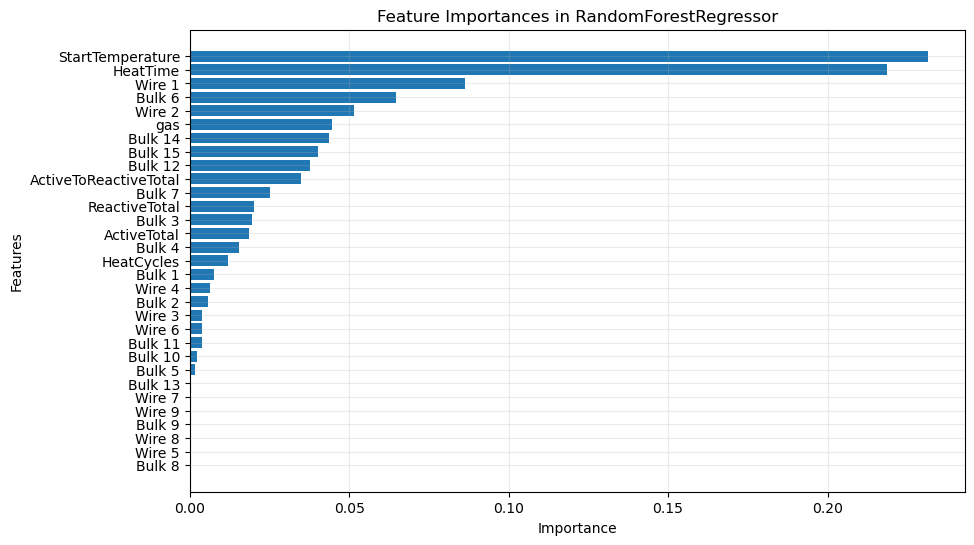

In [79]:
# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances in RandomForestRegressor')
plt.grid(visible=True, alpha=0.25)
plt.gca().invert_yaxis()
plt.show()

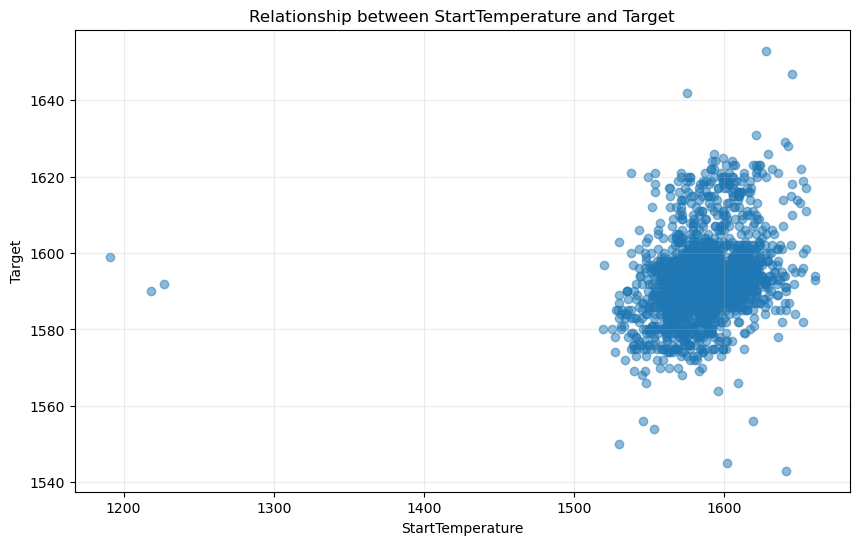

In [80]:
# Выбем самый важный признак
important_feature = feature_importances.iloc[0]['Feature']

# Построение графика зависимости
plt.figure(figsize=(10, 6))
plt.scatter(X_train[important_feature], y_train, alpha=0.5)
plt.xlabel(important_feature)
plt.ylabel('Target')
plt.grid(visible=True, alpha=0.25)
plt.title(f'Relationship between {important_feature} and Target')
plt.show()

На графике мы можем видеть отношение самого важного признака StartTemperature к целевому признаку Temperature. Визуально видно, что большинство точек сосредоточено в диапазоне значений StartTemperature от примерно 1550 до 1650, а целевые значения лежат в диапазоне от примерно 1560 до 1620. Это говорит о том, что большинство наблюдений имеют подобные значения как по StartTemperature, так и по целевому признаку. При этом линейной зависимости не наблюдается.

Несмотря на отсутствие четкой линейной зависимости, StartTemperature был определен моделью как важный признак. Это может означать, что его влияние на целевую переменную важно, но это влияние, скорее всего, нелинейно или зависит от взаимодействия с другими признаками.

## Вывод

Мы провели исследовательский анализ данных, сгенерировали новые признаки, объединили данные и исследовали корреляцию в данных. 

После этого мы обучили несколько моделей: RandomForestRegressor, SGD, LightGBM, и нейросеть Multilayer Perceptron. 

Лучше всего себя показала модель RandomForestRegressor. Протестировав модель на тестовой выборке мы получили целевое значение MAE, равное 6.5492. Это ниже требуемого значения в MAE 6.8

В конце мы провели исследование важности признаков в модели и можем выделить, что признаки StartTemperature, HeatTime, Wire 1, Bulk 6 оказывают существенное влияние на предсказания модели.